In [2]:
import os
print(os.getcwd())
os.chdir("/root/stat542")
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
gc.collect()
torch.cuda.empty_cache()


/root/stat542


ModuleNotFoundError: No module named 'pandas'

* Slightly Overfitting but stable

Loaded 5994 training and 5794 testing images.
=== Train ===
[Epoch 01] Loss=5.2999 | Train=0.37% | Test=9.70%
[Epoch 02] Loss=5.2909 | Train=1.74% | Test=18.42%
[Epoch 03] Loss=5.2764 | Train=5.76% | Test=34.93%
[Epoch 04] Loss=5.2531 | Train=15.40% | Test=37.28%
[Epoch 05] Loss=5.2198 | Train=21.55% | Test=36.45%
[Epoch 06] Loss=5.1783 | Train=25.03% | Test=35.02%
[Epoch 07] Loss=5.1313 | Train=25.54% | Test=31.19%
[Epoch 08] Loss=5.0800 | Train=24.92% | Test=31.29%
[Epoch 09] Loss=5.0248 | Train=26.63% | Test=30.64%
[Epoch 10] Loss=4.9713 | Train=26.11% | Test=29.60%
[Epoch 11] Loss=4.9162 | Train=24.92% | Test=30.32%
[Epoch 12] Loss=4.8622 | Train=28.40% | Test=29.70%
[Epoch 13] Loss=4.8067 | Train=29.75% | Test=30.70%
[Epoch 14] Loss=4.7530 | Train=28.96% | Test=31.14%
[Epoch 15] Loss=4.7019 | Train=30.08% | Test=32.24%
[Epoch 16] Loss=4.6465 | Train=30.65% | Test=31.43%
[Epoch 17] Loss=4.5955 | Train=31.80% | Test=32.72%
[Epoch 18] Loss=4.5472 | Train=32.33% | Test=34.78%
[Epoch 1

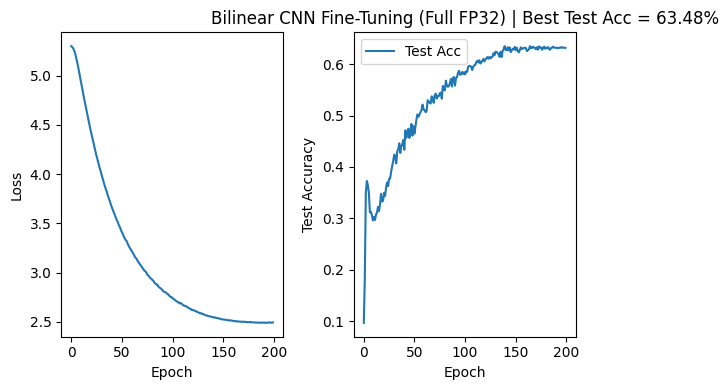

In [9]:
# ============================================================
# Bilinear CNN (Full Fine-Tuning, No AMP)
# Dataset: CUB-200-2011
# ============================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# ============================================================
# Dataset
# ============================================================
class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        img_txt = os.path.join(root, "images.txt")
        label_txt = os.path.join(root, "image_class_labels.txt")
        split_txt = os.path.join(root, "train_test_split.txt")

        with open(img_txt) as f:
            lines = [line.strip() for line in f]
        with open(label_txt) as f:
            labels = [int(l.split()[1]) - 1 for l in f]
        with open(split_txt) as f:
            splits = [int(l.split()[1]) for l in f]

        self.samples = []
        for i, line in enumerate(lines):
            if (train and splits[i] == 1) or (not train and splits[i] == 0):
                img_path = os.path.join(root, "images", line.split()[1])
                self.samples.append((img_path, labels[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# ============================================================
# Bilinear CNN Model
# ============================================================
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=200, dropout_p=0.25):
        super().__init__()
        backbone = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1) #pre-trained weights
        self.features = nn.Sequential(*list(backbone.features.children())[:-1])
        self.num_features = 512
        self.fc = nn.Linear(self.num_features * self.num_features, num_classes)
        nn.init.kaiming_uniform_(self.fc.weight, nonlinearity="linear")
        nn.init.constant_(self.fc.bias, 0.0)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = self.features(x)               # (B, 512, H, W)
        B, C, H, W = x.size()
        x = x + 1e-5                       # small bias to prevent zero maps
        x = x.view(B, C, H * W)
        x = torch.bmm(x, x.transpose(1, 2)) / (H * W)
        x = x.view(B, -1)
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)
        x = F.normalize(x, dim=1)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return self.fc(x)


# ============================================================
# Training / Evaluation
# ============================================================
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def test(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    return total_loss / total_samples, total_correct / total_samples


# ============================================================
# Main Training Pipeline
# ============================================================
if __name__ == "__main__":
    data_root = "data/CUB_200_2011"

    # --- Transforms ---
    train_transform = transforms.Compose([
    transforms.RandomResizedCrop(448, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
    test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

    # --- Datasets ---
    train_data = CUBDataset(data_root, train=True, transform=train_transform)
    test_data = CUBDataset(data_root, train=False, transform=test_transform)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=20, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=20, pin_memory=True)
    print(f"Loaded {len(train_data)} training and {len(test_data)} testing images.")

    # --- Model & Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BilinearCNN(num_classes=200).to(device)
    criterion = nn.CrossEntropyLoss()

    # --- Optimizer ---
    optimizer = torch.optim.SGD([
    {"params": model.features[:10].parameters(), "lr": 5e-4},
    {"params": model.features[10:20].parameters(), "lr": 1e-3},
    {"params": model.features[20:].parameters(), "lr": 2e-3},
    {"params": model.fc.parameters(), "lr": 1e-2},
], momentum=0.9, weight_decay=1e-3)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

    # --- Training ---
    print("=== Train ===")
    best_acc = 0.0
    loss_hist, acc_hist = [], []

    for epoch in range(200):
        tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device)
        te_loss, te_acc = test(model, test_loader, criterion, device)
        scheduler.step()

        print(f"[Epoch {epoch+1:02d}] Loss={tr_loss:.4f} | Train={tr_acc*100:.2f}% | Test={te_acc*100:.2f}%")
        loss_hist.append(tr_loss)
        acc_hist.append(te_acc)

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), "best_bcnn_fullfloat.pt")

   # --- Visualization ---
    plt.figure(figsize=(6, 4))
    plt.subplot(1,2,1)
    plt.plot(loss_hist, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(acc_hist, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title(f"Bilinear CNN Fine-Tuning (Full FP32) | Best Test Acc = {best_acc*100:.2f}%")
    plt.legend()
    plt.tight_layout()
    plt.show()

* Enable Learning Rate Switch

In [ ]:
# ============================================================
# Bilinear CNN (Full Fine-Tuning, Two-Phase LR Schedule)
# Dataset: CUB-200-2011
# ============================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# ============================================================
# Dataset
# ============================================================
class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        img_txt = os.path.join(root, "images.txt")
        label_txt = os.path.join(root, "image_class_labels.txt")
        split_txt = os.path.join(root, "train_test_split.txt")

        with open(img_txt) as f:
            lines = [line.strip() for line in f]
        with open(label_txt) as f:
            labels = [int(l.split()[1]) - 1 for l in f]
        with open(split_txt) as f:
            splits = [int(l.split()[1]) for l in f]

        self.samples = []
        for i, line in enumerate(lines):
            if (train and splits[i] == 1) or (not train and splits[i] == 0):
                img_path = os.path.join(root, "images", line.split()[1])
                self.samples.append((img_path, labels[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# ============================================================
# Bilinear CNN Model
# ============================================================
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=200, dropout_p=0.25):
        super().__init__()
        backbone = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.features.children())[:-1])
        self.num_features = 512
        self.fc = nn.Linear(self.num_features * self.num_features, num_classes)
        nn.init.kaiming_uniform_(self.fc.weight, nonlinearity="linear")
        nn.init.constant_(self.fc.bias, 0.0)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = self.features(x)               # (B, 512, H, W)
        B, C, H, W = x.size()
        x = x + 1e-5                       # avoid zeros
        x = x.view(B, C, H * W)
        x = torch.bmm(x, x.transpose(1, 2)) / (H * W)
        x = x.view(B, -1)
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)
        x = F.normalize(x, dim=1)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return self.fc(x)


# ============================================================
# Train / Eval
# ============================================================
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def test(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    return total_loss / total_samples, total_correct / total_samples


# ============================================================
# Main
# ============================================================
if __name__ == "__main__":
    data_root = "data/CUB_200_2011"

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(448, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
        transforms.RandomRotation(20),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    train_data = CUBDataset(data_root, train=True, transform=train_transform)
    test_data = CUBDataset(data_root, train=False, transform=test_transform)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=20, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=20, pin_memory=True)
    print(f"Loaded {len(train_data)} training and {len(test_data)} testing images.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BilinearCNN(num_classes=200).to(device)
    criterion = nn.CrossEntropyLoss()

    # --- Initial (High LR) Optimizer ---
    optimizer = torch.optim.SGD([
        {"params": model.features[:10].parameters(), "lr": 5e-3},
        {"params": model.features[10:20].parameters(), "lr": 1e-2},
        {"params": model.features[20:].parameters(), "lr": 2e-3},
        {"params": model.fc.parameters(), "lr": 1e-2},
    ], momentum=0.9, weight_decay=1e-3)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-6)

    # --- Training ---
    print("=== Two-Phase Training ===")
    best_acc = 0.0
    loss_hist, acc_hist = [], []

    for epoch in range(250):
        # === LR switch after epoch 100 ===
        if epoch == 100:
            print("\n>>> Switching to fine-tuning phase (lower LR) <<<\n")
            optimizer = torch.optim.SGD([
                {"params": model.features[:10].parameters(), "lr": 5e-5},
                {"params": model.features[10:20].parameters(), "lr": 1e-4},
                {"params": model.features[20:].parameters(), "lr": 2e-4},
                {"params": model.fc.parameters(), "lr": 1e-3},
            ], momentum=0.9, weight_decay=1e-3)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-6)

        tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, device)
        te_loss, te_acc = test(model, test_loader, criterion, device)
        scheduler.step()

        print(f"[Epoch {epoch+1:03d}] Loss(train)={tr_loss:.4f} | Train={tr_acc*100:.2f}% | Test={te_acc*100:.2f}%|| Loss(test)={te_loss*100:.2f}%")
        trloss_hist.append(tr_loss)
        teloss_hist.append(te_loss)
        acc_hist.append(te_acc)

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), "best_bcnn_two_phase.pt")

    # --- Plot ---
    plt.figure(figsize=(6, 4))
    plt.subplot(1,2,1)
    plt.plot(loss_hist, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(acc_hist, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title(f"Bilinear CNN Fine-Tuning (Two-Phase) | Best Test Acc = {best_acc*100:.2f}%")
    plt.legend()
    plt.tight_layout()
    plt.show()
